# FABRIC Experimenters Workshop: Jupyter/API Demo


## Configure the Environment

### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework. 

#### Orchestrator Proxy

Manages requests and queries for FABRIC resources. 

#### Credential Manager Proxy

Manages tokens that authorize requests. 

Fabric uses two kinds of tokens:

- Refresh Token: When user logins to Jupyterhub after authenticating against CILogon, an initial refresh token is derived. This token is available as the environment variable `CILOGON_REFRESH_TOKEN` and is used to generate the initial Identity Token. On every refresh, Fabric Refresh Token is changed and updated. Each Refresh Token is valid for 24 hours.

- Identity Token: The control/measurement framework APIs require an Identity Token. Identity tokens can be generated from a valid Refresh Token at any time. Each Identity Token is valid upto an hour.



In [1]:
import os
import json

from fabric_cm.credmgr.credmgr_proxy import CredmgrProxy
from fabric_cf.orchestrator.orchestrator_proxy import OrchestratorProxy

#Create a FABRIC Orchestrator Proxy.
orchestrator_proxy = OrchestratorProxy(orchestrator_host=os.environ['FABRIC_ORCHESTRATOR_HOST'])

#Create a Credential Manager Proxy 
credmgr_proxy = CredmgrProxy(credmgr_host=os.environ['FABRIC_CREDMGR_HOST'])

#Cofigure SSH Key
ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read().strip()


### Save the Initial Refresh Token

In [2]:
#Retrieve or set the refresh token (exprires 24 hours after login)
fabric_refresh_token=None
%store -r fabric_refresh_token
if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token

print("Refresh Token: {}".format(fabric_refresh_token))

Refresh Token: https://cilogon.org/oauth2/refreshToken/470ef542f1fe0d3abb47fd45e9e44429/1617880455180


### Refresh the ID Token

ID Tokens expire one hour after refresh. 

In [45]:
try:
    refresh_res = credmgr_proxy.refresh(project_name='all', scope='all', refresh_token=fabric_refresh_token)

    fabric_id_token=refresh_res['id_token']
    fabric_refresh_token=refresh_res['refresh_token']
    print("New Refreash Token: {}\n".format(fabric_refresh_token))
    print("New ID Token: {}".format(fabric_id_token))
    %store fabric_refresh_token

except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))
    

Exception occurred while getting tokens:('INTERNAL SERVER ERROR', '"(\\"server_error\\"\\nerror_description=\\"No transaction found for identifier \\"https://cilogon.org/oauth2/refreshToken/d250626c4d9938462a2f527acfd2ef8/1617880572775\\"\\"\\n) "\n')


## Getting Help

In [4]:
help(CredmgrProxy)

Help on class CredmgrProxy in module fabric_cm.credmgr.credmgr_proxy:

class CredmgrProxy(builtins.object)
 |  CredmgrProxy(credmgr_host: str)
 |  
 |  Credential Manager Proxy
 |  
 |  Methods defined here:
 |  
 |  __init__(self, credmgr_host: str)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  certs_get(self)
 |      Return certificates
 |  
 |  refresh(self, project_name: str, scope: str, refresh_token: str) -> dict
 |      Refresh token
 |      @param project_name project name
 |      @param scope scope
 |      @param refresh_token refresh token
 |      @returns the dictionary containing the tokens
 |      @raises Exception in case of failure
 |  
 |  revoke(self, refresh_token: str) -> str
 |      Revoke token
 |      @param refresh_token refresh token
 |      @returns response
 |      @raises Exception in case of failure
 |  
 |  version_get(self)
 |      Return Version
 |  
 |  --------------------------------------------------------------------

In [5]:
help(OrchestratorProxy)

Help on class OrchestratorProxy in module fabric_cf.orchestrator.orchestrator_proxy:

class OrchestratorProxy(builtins.object)
 |  OrchestratorProxy(orchestrator_host: str)
 |  
 |  Orchestrator Proxy; must specify the orchestrator host details when instantiating the proxy object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, orchestrator_host: str)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  create(self, *, token: str, slice_name: str, ssh_key: str, topology: fim.user.topology.ExperimentTopology = None, slice_graph: str = None) -> Tuple[fabric_cf.orchestrator.orchestrator_proxy.Status, Union[Exception, List[fabric_cf.orchestrator.elements.reservation.Reservation]]]
 |      Create a slice
 |      @param token fabric token
 |      @param slice_name slice name
 |      @param topology Experiment topology
 |      @param slice_graph Slice Graph string
 |      @return Tuple containing Status and Exception/Json containing slivers created
 |  
 |  de

## Query Resource Availability 

### Get Advertisement from Proxy

In [6]:
status, advertised_topology = orchestrator_proxy.resources(token=fabric_id_token)

print(f"Status: {status}")
print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL: { cpu: 6/6, core: 92/96, ram: 1504/1536G, disk: 109400/109600G, unit: 3/3, }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 0/2, }
	Site Interfaces:
RENC: { cpu: 6/6, core: 94/96, ram: 1520/1536G, disk: 109500/109600G, unit: 3/3, }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2, }
		NVME-P4510:  NVME P4510 { disk: 9000/10000G, unit: 9/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 1/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 2/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
	Site Interfaces:
UKY: { cpu: 6/6, core: 88/96, ram: 1472/1536G, disk: 109100/109600G, unit: 3/3, }
	Comp

### Display Resource Topology

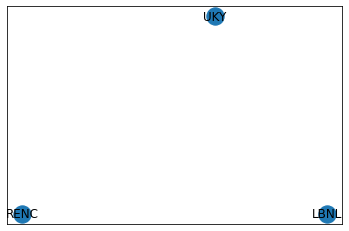

In [7]:
advertised_topology.draw()

## Build Slice Request

<!---
<img src="./figs/AllNodes.png" width="90%"><br>
-->


In [28]:
import fim.user as fu

# Create Experiment Topology
experiemnt = fu.ExperimentTopology()

slice_name="DemoSlice"

In [29]:
help(fu.ExperimentTopology)

Help on class ExperimentTopology in module fim.user.topology:

class ExperimentTopology(Topology)
 |  ExperimentTopology(graph_file: str = None, graph_string: str = None, logger=None)
 |  
 |  Define an user topology model, inheriting behavior from Topology class.
 |  In addition to publicly visible methods the following calls can be made:
 |  topology.nodes - a read-only dictionary of nodes in the topology
 |  topology.links - a read-only dictionary of links in the topology
 |  topology.interface_list - a read-only list of all interfaces of all nodes
 |  If you want to operate on top of a Neo4j graph, use the cast() method.
 |  
 |  Method resolution order:
 |      ExperimentTopology
 |      Topology
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, graph_file: str = None, graph_string: str = None, logger=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cast(self, *, asm_graph: fim.graph.slices.abc_asm.A

### Add Node1 at RENC
<img src="./figs/Node1.png" width="40%"><br>

In [30]:
# Add Node1 with: GPU: 1xSharedConnectX-6, 1xRTX6000, 1xP4510
node1 = experiemnt.add_node(name='node1', site='RENC')

node1_capacity = fu.Capacities()
node1_capacity.set_fields(core=2, ram=16, disk=100)
node1.set_properties(capacities=node1_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node1_nvme = node1.add_component(ctype=fu.ComponentType.NVME, model='P4510', name='n1_nvme')
node1_gpu  = node1.add_component(ctype=fu.ComponentType.GPU, model='RTX6000', name='n1_gpu')
node1_nic = node1.add_component(ctype=fu.ComponentType.SharedNIC, model='ConnectX-6', name='n1_nic')

### Add Node2 at LBNL
<img src="./figs/Node2.png" width="40%"><br>

In [31]:
# Add Node2 with: FastNet: 2xConnectX-5, 2xT4
node2 = experiemnt.add_node(name='node2', site='LBNL')

node2_capacity = fu.Capacities()
node2_capacity.set_fields(core=4, ram=32, disk=200)
node2.set_properties(capacities=node2_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node2_gpu1  = node2.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='n2_gpu1')
node2_gpu2  = node2.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='n2_gpu2')
node2_nvme1 = node2.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='n2_nic1')
node2_nvme2 = node2.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='n2_nic2')

### Add Node3 at UKY
<img src="./figs/Node3.png" width="40%"><br>

In [32]:
# Add Node with: SlowNet: 1xConnectX-6, 2xT4, 4xP4510
node3 = experiemnt.add_node(name='node3', site='UKY')

node3_capacity = fu.Capacities()
node3_capacity.set_fields(core=8, ram=64, disk=500)
node3.set_properties(capacities=node3_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node3_nvme1 = node3.add_component(ctype=fu.ComponentType.NVME, model='P4510', name='n3_nvme1')
node3_nvme2 = node3.add_component(ctype=fu.ComponentType.NVME, model='P4510', name='n3_nvme2')
node3_nvme3 = node3.add_component(ctype=fu.ComponentType.NVME, model='P4510', name='n3_nvme3')
node3_nvme4 = node3.add_component(ctype=fu.ComponentType.NVME, model='P4510', name='n3_nvme4')
node3_gpu1  = node3.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='n3_gpu1')
node3_gpu2  = node3.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='n3_gpu2')
#node3_nic1 = node3.add_component(ctype=fu.ComponentType.SharedNIC, model='ConnectX-6', name='n3_nic1')

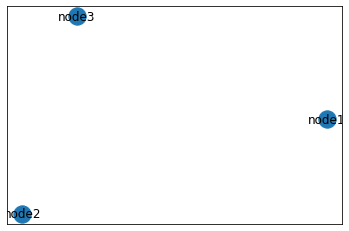

In [33]:
# Generate Slice Graph
#slice_graph = t.serialize()
experiemnt.draw()

## Submit the Request

In [34]:
slice_graph = experiemnt.serialize()

# Request slice from Orchestrator
status, reservations = orchestrator_proxy.create(token=fabric_id_token, slice_name=slice_name, slice_graph=slice_graph, ssh_key=ssh_key)


print("Request {}".format(status))
slice_id=reservations[0].slice_id

print("Reservations: {}".format(reservations))
print("Slice ID: {}".format(slice_id))

Request Status.OK
Reservations: [{
    "graph_node_id": "f9288304-bc43-4438-a9b7-9433377425a3",
    "join_state": "None_",
    "lease_end": "2021-04-09 11:24:31",
    "reservation_id": "2d5adf14-96b7-4f07-9c36-c639d39bc043",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}, {
    "graph_node_id": "2cb35a82-7347-4f8d-a415-5748139502a7",
    "join_state": "None_",
    "lease_end": "2021-04-09 11:24:31",
    "reservation_id": "d09a7c96-1c39-4297-8be5-b068d165f468",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}, {
    "graph_node_id": "6b631617-10c8-4c6c-8675-344e9c17740f",
    "join_state": "None_",
    "lease_end": "2021-04-09 11:24:31",
    "reservation_id": "8873450a-b3f4-4402-b998-34ab89bb8733",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}]
Slice ID: a2d1e1a1-8e0e-45b2

## Query Slices

In [37]:
status, slices = orchestrator_proxy.slices(token=fabric_id_token)

print("Response Status {}".format(status))
print("Slices {}".format(slices))

Response Status Status.OK
Slices [{
    "graph_id": "c19ffdf2-36e5-4bf7-adcc-be4ba7c57dbe",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0",
    "slice_name": "DemoSlice",
    "slice_state": "StableOK"
}]


## Slice Status

In [38]:
import time

slice_state=None
while slice_state != 'StableOK':
    status, slice_status = orchestrator_proxy.slice_status(token=fabric_id_token, slice_id=slice_id)
    slice_state = slice_status.slice_state
    print("Response Status {}".format(status))
    print("Slice State: {}".format(slices[0].slice_state))
    time.sleep(20)

#status, slice_status = orchestrator_proxy.slice_status(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Slice Status {}".format(slice_status))

Slice State: StableOK
Response Status Status.OK
Slice Status {
    "graph_id": "c19ffdf2-36e5-4bf7-adcc-be4ba7c57dbe",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0",
    "slice_name": "DemoSlice",
    "slice_state": "StableOK"
}


## Query Slivers

In [39]:
status, slivers = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Slivers {}".format(reservations))

Response Status Status.OK
Slivers [{
    "graph_node_id": "f9288304-bc43-4438-a9b7-9433377425a3",
    "join_state": "None_",
    "lease_end": "2021-04-09 11:24:31",
    "reservation_id": "2d5adf14-96b7-4f07-9c36-c639d39bc043",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}, {
    "graph_node_id": "2cb35a82-7347-4f8d-a415-5748139502a7",
    "join_state": "None_",
    "lease_end": "2021-04-09 11:24:31",
    "reservation_id": "d09a7c96-1c39-4297-8be5-b068d165f468",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}, {
    "graph_node_id": "6b631617-10c8-4c6c-8675-344e9c17740f",
    "join_state": "None_",
    "lease_end": "2021-04-09 11:24:31",
    "reservation_id": "8873450a-b3f4-4402-b998-34ab89bb8733",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}]


## Sliver Status

In [41]:
for sliver in slivers:
    sliver_id=sliver.reservation_id
    status, reservation_status = orchestrator_proxy.sliver_status(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)

    print("Response Status {}".format(status))
    print("Reservation Status {}".format(reservation_status))

Response Status Status.OK
Reservation Status {
    "capacities": "{\"core\": 8, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "6b631617-10c8-4c6c-8675-344e9c17740f",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "2021-04-09 11:24:31",
    "management_ip": "128.163.179.35",
    "name": "node3",
    "notices": "Reservation 8873450a-b3f4-4402-b998-34ab89bb8733 (Slice DemoSlice(a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0) Graph Id:c19ffdf2-36e5-4bf7-adcc-be4ba7c57dbe ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "reservation_id": "8873450a-b3f4-4402-b998-34ab89bb8733",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "UKY",
    "slice_id": "a2d1e1a1-8e0e-45b2-875d-d000cfde6fb0"
}
Response Status Status.OK
Reservation Status {
    "capacities": "{\"core\": 2, \"disk\": 100, \"ram\": 16}",
    "graph_node_id": "f9288304-bc43-4438-a9b7-9433377425a3",
    "join_state": "NoJoin",
    "la

## Configure the Nodes

In [43]:
script= '#!/bin/bash  \n' \
        'lspci  \n'

In [44]:
import paramiko 
#from scp import SCPClient, SCPException

key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

for sliver in slivers:
    node_name = sliver.name
    management_ip = sliver.management_ip
    
    print("Node {0} IP {1}".format(node_name, management_ip))
    
    client.connect(management_ip,username='ubuntu',pkey = key)

    stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
    print ('')
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

    client.close()

Node node3 IP 128.163.179.35

00:00.0 Host bridge: Intel Corporation 440FX - 82441FX PMC [Natoma] (rev 02)
00:01.0 ISA bridge: Intel Corporation 82371SB PIIX3 ISA [Natoma/Triton II]
00:01.1 IDE interface: Intel Corporation 82371SB PIIX3 IDE [Natoma/Triton II]
00:01.2 USB controller: Intel Corporation 82371SB PIIX3 USB [Natoma/Triton II] (rev 01)
00:01.3 Bridge: Intel Corporation 82371AB/EB/MB PIIX4 ACPI (rev 03)
00:02.0 VGA compatible controller: Cirrus Logic GD 5446
00:03.0 Ethernet controller: Red Hat, Inc. Virtio network device
00:04.0 SCSI storage controller: Red Hat, Inc. Virtio block device
00:05.0 Unclassified device [00ff]: Red Hat, Inc. Virtio memory balloon
00:06.0 Unclassified device [00ff]: Red Hat, Inc. Virtio RNG
00:07.0 Non-Volatile memory controller: Intel Corporation NVMe Datacenter SSD [3DNAND, Beta Rock Controller]
00:08.0 Non-Volatile memory controller: Intel Corporation NVMe Datacenter SSD [3DNAND, Beta Rock Controller]
00:09.0 Non-Volatile memory controller: Intel

## Delete Slice

In [16]:
status, result = orchestrator_proxy.delete(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

NameError: name 'slice_id' is not defined